In [11]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import utils.minimization as minim
from utils.minimization import SolverLLS, StoppingCondition

In [12]:
# Reloading modules
importlib.reload(minim)

<module 'utils.minimization' from 'C:\\Users\\steur\\PycharmProjects\\ICT4Health\\utils\\minimization.py'>

In [13]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns  # first columns will contain the names of the features
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')
# print(features)

Dataset size = (5875, 22)
Dataset features count = 22


Features list:
- subject#: patient number
- age: age of the patient
- sex: sex of the patient
- test_time: period from the beginning of the measurement (integer -> day, float -> hour from 0AM to 12PM)
- motor_UPDRS:
- total_UPDRS:
Jitter, in general, is the variation of the fundamental frequency in signals that should be periodic but are not
- Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP
Shimmer, in general, is the variation of amplitude in signals that should be periodic but are not
- Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shipper:APQ11, Shimmer:DDA
- NHR: Noise to Harmonics Ratio
- HNR: Harmonic to Noise Ratio
- RPDE: Recurrence Period Density Entropy
- DFA: Detrended Fluctuation Analysis
- PPE: Perceived Vocal Effort is the measure of effort (physical and cognitive) used to produce speech

<Axes: ylabel='Frequency'>

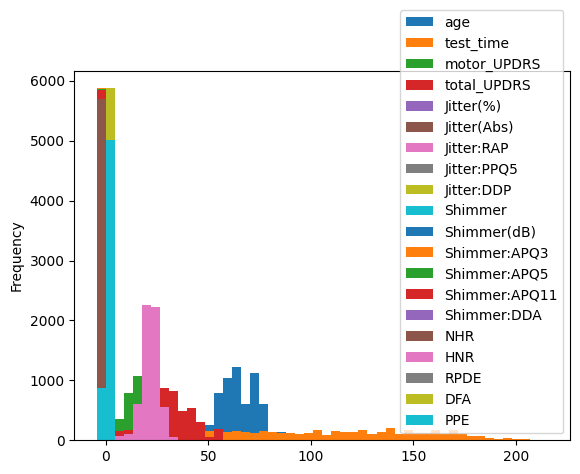

In [14]:
# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(
    bins=50)  # 'subject#' and 'sex' are removed to have a crearer histogram
# bins is the number of rectangles, so the lesser -> the more values will be represented with a single rectangle

In [15]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:  # for each subject#
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()
    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']  # new property called 'g' containing the 'test_time' property
    # now the dataframe collapses using 'g' as pivot, and computing the mean for each other property
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along rows. (0, 1) -> (rows, columns)
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


Printing X.cov() will give as result that the feature 'test_time' has a large variance (in the matrix, 'test_time' againist
'test_time'), so normalization is needed

In [16]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

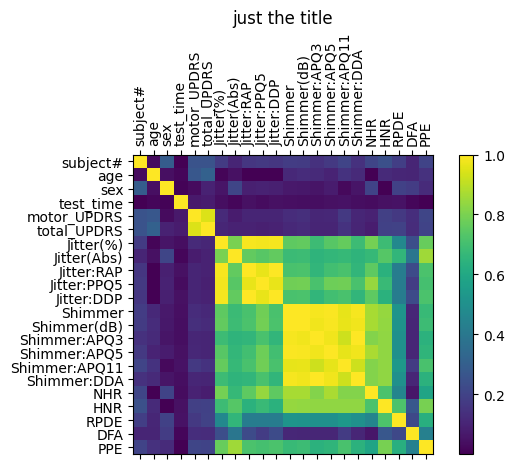

In [17]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

The picture shows correlation between motor_UPDRS and total_UPDRS, but also between jitter and shimmer parameters. this mai
result in collinearity. Removing all but one (the one with the highest correlation with regressand) correlated features can
be the way to have good regression results (in particular, one single solution) 

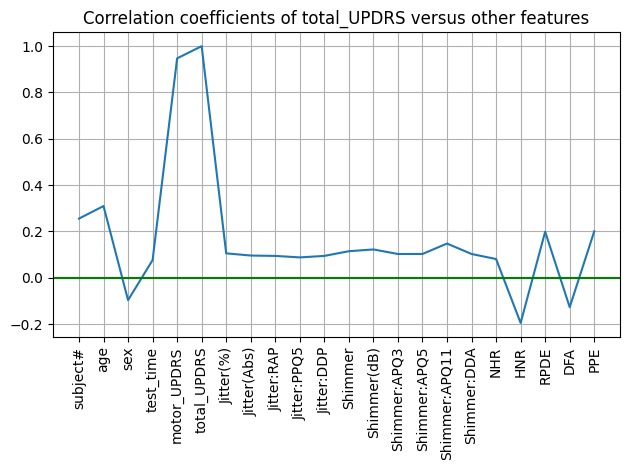

In [18]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

This plot shows correlation between total_UPDRS and motor_UPDRS and low correlation with voice parameters.
The subject# has to be removed from regressors because it is not logically correlated to any property.

In [19]:
seed = 30
# Shuffling is needed to avoid that only data from the first patient is used for the training. This is
# to pretend that all the measurements are taken from different patients in different stages of the illness.
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)

In [20]:
Ntr = int(Np * 0.5)  # Number of training points
Nte = Np - Ntr  # Number of test points
X_tr = Xsh[:Ntr]
mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [21]:
Xsh_norm = (Xsh - mm_vals) / ss_vals  # normalization of all parameters
ysh_norm = Xsh_norm['total_UPDRS']  # total_UPDRS will be the regressand
Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#'], axis=1)   # removing the regressand and other useless
# or known correlated features

X_tr_norm = Xsh_norm[:Ntr]
X_te_norm = Xsh_norm[Ntr:]
y_tr_norm = ysh_norm[:Ntr]
y_te_norm = ysh_norm[Ntr:]

In [22]:
solver = SolverLLS(X_tr_norm, y_tr_norm)
solver.solve()
w_hat = solver.result

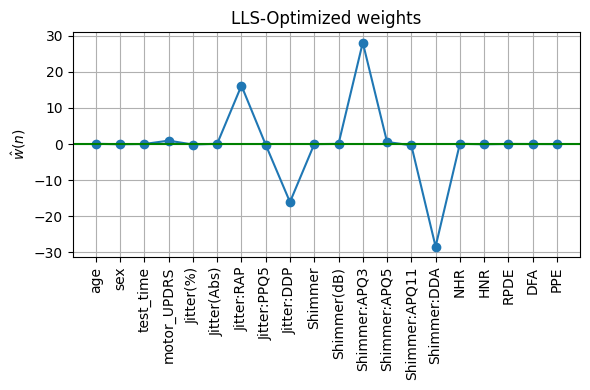

In [23]:
regressors = X_tr_norm
Nf = len(w_hat)
nn = np.arange(Nf)
plt.figure(figsize=(6, 4))
plt.plot(nn, w_hat, '-o')
ticks = nn
plt.xticks(ticks, regressors, rotation=90)
plt.ylabel(r'$\^w(n)$')
plt.title('LLS-Optimized weights')
plt.grid()
plt.axhline(y=0, color='g')
plt.tight_layout()
plt.savefig('./LLS-w_hat.png')
plt.show()

This plot shows anti-correlation between Jitter:RAP and Jitter:DDP and between Shimmer:APQ3 and Shimmer:DDA.
The features with the minus will be removed on part two.

In [24]:
y_hat_te_norm = X_te_norm @ w_hat
y_hat_tr_norm = X_tr_norm @ w_hat

In [25]:
# De-normalization, to make data readable by a medical doctor
y_hat_tr = y_hat_tr_norm * sy + my
y_tr = y_tr_norm * sy + my
y_hat_te = y_hat_te_norm * sy + my
y_te = y_te_norm * sy + my

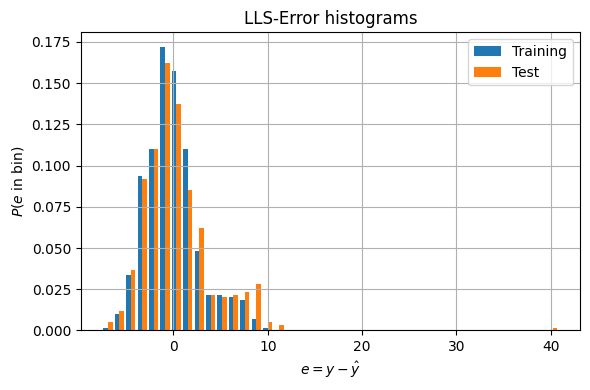

In [26]:
E_tr = y_tr - y_hat_tr
E_te = y_te - y_hat_te
e = [E_tr, E_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Training', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.grid()
plt.title('LLS-Error histograms')
plt.tight_layout()
plt.savefig('./LLS-Error-hist.png')
plt.show()

The last plot shows that the error pdf is like a mixture of two gaussian pdfs.
The fact that the two pdfs of training and test looks very similar is because there's no overfitting. If overfitting
was present, the error in the training would have been more concentrated on the 0 value, while the pdf of the test
would have depended on the similarity of the two datasets: if similar, the two pdfs could have been similar, otherwise
the test one would have its peak near the average distance, in height, from the regression line. (Discuss this)

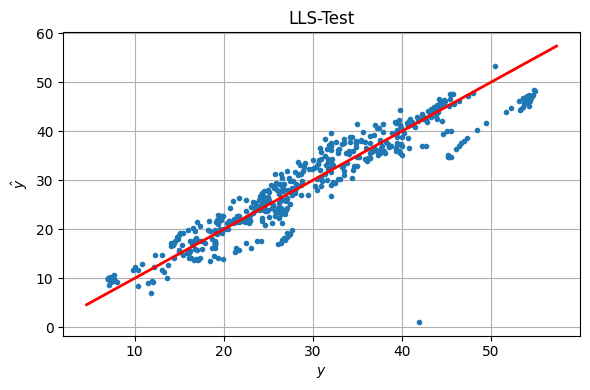

In [27]:
y_hat_te = (X_te_norm @ w_hat) * sy + my
y_te = y_te_norm * sy + my
plt.figure(figsize=(6, 4))
plt.plot(y_te, y_hat_te, '.')
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.grid()
plt.title('LLS-Test')
plt.tight_layout()
plt.savefig('./LLS-yhat_vs_y.png')
plt.show()

The estimation is quite close to the original, except for some cases that stay near 7-8 UPDRS points far from the
original value. This justifies the second gaussian with its average near 7-8. 

In [28]:
E_tr_min = E_tr.min()
E_tr_max = E_tr.max()
E_tr_mu = E_tr.mean()
E_tr_sig = E_tr.std()
E_tr_MSE = np.mean(E_tr ** 2)
R2tr = 1 - E_tr_MSE / np.var(y_tr)
ctr = np.mean((y_tr - y_tr.mean()) * (y_hat_tr - y_hat_tr.mean()))
E_te_min = E_te.min()
E_te_max = E_te.max()
E_te_mu = E_te.mean()
E_te_sig = E_te.std()
E_te_MSE = np.mean(E_te ** 2)
R2te = 1 - E_te_MSE / np.var(y_te)
cte = np.mean((y_te - y_te.mean()) * (y_hat_te - y_hat_te.mean()))

In [29]:
rows = ['Training', 'Test']
cols = ['min', 'max', 'mean', 'std', 'MSE', 'R^2', 'correlation coefficient']
p = np.array([
    [E_tr_min, E_tr_max, E_tr_mu, E_tr_sig, E_tr_MSE, R2tr, ctr],
    [E_te_min, E_te_max, E_te_mu, E_te_sig, E_te_MSE, R2te, cte]
])
results = pd.DataFrame(p, columns=cols, index=rows)
print(results)

               min        max          mean       std        MSE       R^2  \
Training -7.503529  10.468688 -8.390146e-14  2.888472   8.326418  0.922054   
Test     -7.539036  40.810008  3.785802e-01  3.908652  15.390022  0.873411   

          correlation coefficient  
Training                98.495844  
Test                   107.831273  
